# December Questions from Dave Turner (Question 2)

__2022/02/01__

Meeting with Dave is 2022/02/01 at 4:30pm.

Notes from our last conversation from my lab notebook:  

"
1. _The CO2 band is telling us about the conditions of the stratosphere. There is a decrease in OLR (cooling) in the fall and January, and increase in OLR (warming) and March and April. Is this consistent with observations of stratospheric temperatures? What is driving these changes?_

2. _There appears to be a decrease in OLR in JJA. Is this from surface temperatures (doubtful), clouds (maybe), water vapor (more likely)? Try the spatio-temporal correlation with the spectral bands just for these months._  

3. _To tease out the effect of clouds on the OLR vs. WV. Pick two water vapor bands with similar optical depth (calculate how) but in different portions of spectrum. Dave suggested 400 +/- 10 cm-1 (FIR) and 6.7um (v2). In a clear-sky scenario, the trends should basically be the same after correcting for planck emission differences because absorption is dominated by WV. In a full-sky scenario, however, the FIR band should have much more FIR scattering than the 6.7um band if clouds are important. A key caveat: this product is derived and would need to have clouds and LW scattering implemented to show this effect. Also if clouds aren’t changing we wouldn’t see it either. This becomes kind of messy._  

"

I will try and go through and investigate each of these questions. Might have to split this notebook into several notebooks so there aren't memory issues and the code remains clear.

### Do imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps,
    glob, copy
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, regress_1d,
    to_png, polarCentral_set_latlim, add_map_features,
    stats, plot_trends, MidpointNormalize
    )

import copy
from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 2. Decrease in OLR in JJA

__There appears to be a decrease in OLR in JJA. Is this from surface temperatures (doubtful), clouds (maybe), water vapor (more likely)? Try the spatio-temporal correlation with the spectral bands just for these months.__

So I want to do a spatio-temporal correlation between JJA OLR trends (or just OLR?) and water vapor change. Here, I will want to be smart about the water vapor value that I am correlating. i.e. What regime am I in and how do I expect WV and OLR to be related?

Assume a standard Beer's Law relationship between transmission $t$ and total column water vapor $q$:  

$$ t = e^{-kq}, $$  

where $k$ is some constant such that the optical depth $\tau$ is $\tau = kq$.

For small $q$, $-kq << 1$ and transmission can be expanded using a Taylor series:  

$$ t \approx 1 - kq. $$

Clearly, $\partial t / \partial q \propto q$ in this transparent regime (window bands). For large $kq$, we use  

$$ \frac{\partial t}{\partial \log{q}} = q (-k e^{-kq}). $$

I'm still figuring out why we assume $\partial t / \partial \log{q} = \textrm{const.}$ here.

In summary, I'll test a both approaches when doing spatio temporal correlations.

#### Strategy

I can either correlate the trends, or the actual values. I will try the values first because it is conceptually a clearer connection. Will load AIRS spectral OLR and column WV retrievals. Should be possible to do a full 3d correlation by adding weights, stacking, and then correlating with weights manually.

### Load Data

#### AIRS Spectral OLR

In [2]:
# AIRS spectral OLR
airs_dir = '/glade/work/jonahshaw/obs/AIRS/'
airs_files = glob.glob('%s/proc/**.nc' % airs_dir)
airs_files.sort()

I need the timeseries, not just the linear trends. Will have to try loading the full dataset.

In [3]:
all_airs = xr.open_mfdataset(airs_files,parallel=True,data_vars=['olr_spectral','olr_clr_spectral']) # only took 260mb! (5gB each actual I think)

In [6]:
olr_subset = add_weights(all_airs[['olr_spectral','olr_clr_spectral']].sel(lat=slice(59,None),time=slice('2003-01-01','2018-12-31')).mean(dim='orbit_pass'))

In [29]:
all_airs.close()

In [17]:
def is_jja(month):
    return (month >= 6) & (month <= 8)

In [18]:
olr_jja_subset = olr_subset.sel(time=is_jja(olr_subset['time.month'])) # Select only JJA. 110mb each variable.

In [39]:
# Load subset data into memory (~20s)
olr_jja_subset = olr_jja_subset.compute()

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


#### AIRS Retrieved Column Water Vapor

In [22]:
airs_tseries_dir = '/glade/work/jonahshaw/obs/AIRS/AIRS3STM_7.0/tseries/'

In [23]:
tmq_a_file = 'AIRS.TotH2OVap_A.200209-202012.L3.RetStd.v7.nc'
tmq_d_file = 'AIRS.TotH2OVap_D.200209-202012.L3.RetStd.v7.nc'

In [33]:
tmq_a = xr.open_dataset('%s/%s' % (airs_tseries_dir,tmq_a_file),chunks={'lat': -1, 'lon': -1, 'time': -1}) # chunking is arbitrary
tmq_d = xr.open_dataset('%s/%s' % (airs_tseries_dir,tmq_d_file),chunks={'lat': -1, 'lon': -1, 'time': -1})

tmq_a = tmq_a.rename({'TotH2OVap_A':'TotH2OVap'})
tmq_d = tmq_d.rename({'TotH2OVap_D':'TotH2OVap'})

tmq_a = tmq_a.sel(lat=slice(None,59),time=slice('2003-01-01','2018-12-30'))
tmq_d = tmq_d.sel(lat=slice(None,59),time=slice('2003-01-01','2018-12-30'))

In [36]:
_tmq_a = tmq_a['TotH2OVap'].assign_coords({'orbit':0}).expand_dims('orbit')
_tmq_d = tmq_d['TotH2OVap'].assign_coords({'orbit':1}).expand_dims('orbit')

In [37]:
tmq_net = xr.merge([_tmq_a,_tmq_d])
tmq_net = tmq_net.mean(dim='orbit')['TotH2OVap']

_tmq_a.close()
_tmq_d.close()

In [40]:
tmq_net_jja = tmq_net.sel(time=is_jja(tmq_net['time.month'])) # Select only JJA. 110mb each variable.

In [ ]:
# tmq_net = tmq_net.compute() # not a dask object, so don't need to do this

#### Check out data

In [72]:
tmq_net_jja

<xarray.DataArray 'TotH2OVap' (time: 48, lat: 31, lon: 360)>
dask.array<getitem, shape=(48, 31, 360), dtype=float32, chunksize=(48, 25, 25), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 89.5 88.5 87.5 86.5 85.5 ... 63.5 62.5 61.5 60.5 59.5
  * time     (time) object 2003-06-01 00:00:00 ... 2018-08-01 00:00:00

In [41]:
olr_jja_subset

<xarray.Dataset>
Dimensions:           (lat: 16, lon: 180, time: 48, wnum: 199)
Coordinates:
  * lat               (lat) float32 59.0 61.0 63.0 65.0 ... 83.0 85.0 87.0 89.0
  * wnum              (wnum) float32 15.0 25.0 35.0 ... 1975.0 1985.0 1995.0
  * time              (time) datetime64[ns] 2003-06-15T12:00:00 ... 2018-08-1...
  * lon               (lon) float32 -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
    cell_weight       (lon, lat) float32 0.0006572734 ... 2.2272114e-05
Data variables:
    olr_spectral      (time, wnum, lat, lon) float32 0.013909086 ... nan
    olr_clr_spectral  (time, wnum, lat, lon) float32 nan nan nan ... nan nan nan

Looks like I will need to interpolate the AIRS Standard Retrieval onto the coarser spectral OLR grid before calculating the spatial correlations.

Fix some small things

In [95]:
# Remove top empty latitude bin from AIRS spectral OLR and lowest bin 59 that doesn't fit the retrieval gridding
olr_jja_subset_notop = olr_jja_subset.sel(lat=slice(60,87))

In [96]:
# Set longitude range to the olr range, copy time format from spectral olr to retrieval
tmq_net_jja = tmq_net_jja.assign_coords(lon=(((tmq_net_jja['lon'] + 180) % 360) - 180),time=olr_jja_subset_notop['time']).sortby('lon')

In [ ]:
# cannot compare cftime.Datetime360Day(2003, 6, 1, 0, 0, 0, 0) and Timestamp('2003-06-15 12:00:00') (different calendars)

In [ ]:
# Chunking along the dimension to be interpolated (2) is not yet supported.

In [97]:
# Perform the interpolation (could do better with xESMF)
tmq_net_jja_interp = tmq_net_jja.interp_like(olr_jja_subset_notop)

In [101]:
olr_jja_765 = olr_jja_subset_notop.sel(wnum=765)

In [120]:
stack_olr = olr_jja_765['olr_spectral'].stack(z=('lat', 'lon','time'))

In [111]:
stack_tmq = tmq_net_jja_interp.stack(z=('lat', 'lon','time'))

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0, 0.5, 'Precipitable water vapor (mm)')

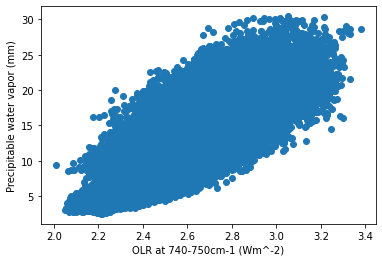

In [181]:
plt.scatter(stack_olr,stack_tmq)

plt.xlabel('OLR at 740-750cm-1 (Wm^-2)')
plt.ylabel('Precipitable water vapor (mm)')

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0, 0.5, 'Log Precipitable water vapor log(mm)')

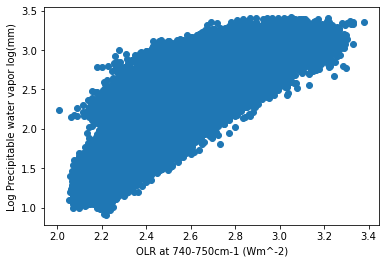

In [180]:
plt.scatter(stack_olr,np.log(stack_tmq))

plt.xlabel('OLR at 740-750cm-1 (Wm^-2)')
plt.ylabel('Log Precipitable water vapor log(mm)')

#### Compare trends spatio-temporally

In [125]:
def linregress2(x, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])

In [126]:
def vectorized_linregress2(data):
    '''
    Package for vectorized linregress call from: 
    https://stackoverflow.com/questions/52094320/with-xarray-how-to-parallelize-1d-operations-on-a-multidimensional-dataset. 
    Not very general.
    '''
    
    regressed_month = xr.apply_ufunc(
        linregress2, data['year'], data,
        input_core_dims=[['year'], ['year']],
        output_core_dims=[["parameter"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=['float64'],
        output_sizes={"parameter": 5},
                      )
    
    return regressed_month

In [145]:
def compute_trends_n_signif2(subset_data):
    '''
    Package the trend calculating lines to save space. V2 uses vectorized_linregress2
    '''
    # create empty arrays for needed output
    _trends = xr.zeros_like(subset_data.groupby('time.month').mean('time')).load()
    _rvalues = _trends.copy()
    _pvalues = _trends.copy()

    # Potentially I should be able to format this to avoid this for loop too
    for ii,(i,_month) in enumerate(subset_data.groupby('time.month')): # fix to handle not all months
        _yearlydata = _month.groupby('time.year').mean('time').chunk({'year': -1}) # let the other dimensions chunk however?
        regressed_month = vectorized_linregress2(_yearlydata)

        # ii = i-1 # the count starts at month 1 (January) but we need to index starting at 0
        
        _trends[ii] = regressed_month.isel(parameter=0)
        _rvalues[ii] = regressed_month.isel(parameter=2)
        _pvalues[ii] = regressed_month.isel(parameter=3)

    # Calculate statistical significance
    N = len(_yearlydata.year)
    dof=N-2

    tcrit=stats.t.ppf(0.975,dof)  ## two-sided 95%
    t=_rvalues*np.sqrt(N-2)/np.sqrt((1-_rvalues*_rvalues))

    _statsig=(1-_pvalues)*100
    _notnull = t > tcrit # disproving the null hypothesis (slope is zero)    
    
    return _trends,_statsig,_notnull

In [160]:
olr_jja_765_trends,olr_jja_765_rvals,olr_jja_765_pvals = compute_trends_n_signif2(olr_jja_765['olr_spectral'])

In [161]:
tmq_net_jja_trends,tmq_net_jja_rvals,tmq_net_jja_pvals = compute_trends_n_signif2(tmq_net_jja_interp)

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/ch

In [167]:
tmq_log_jja_trends,tmq_log_jja_rvals,tmq_log_jja_pvals = compute_trends_n_signif2(np.log(tmq_net_jja_interp))

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/ch

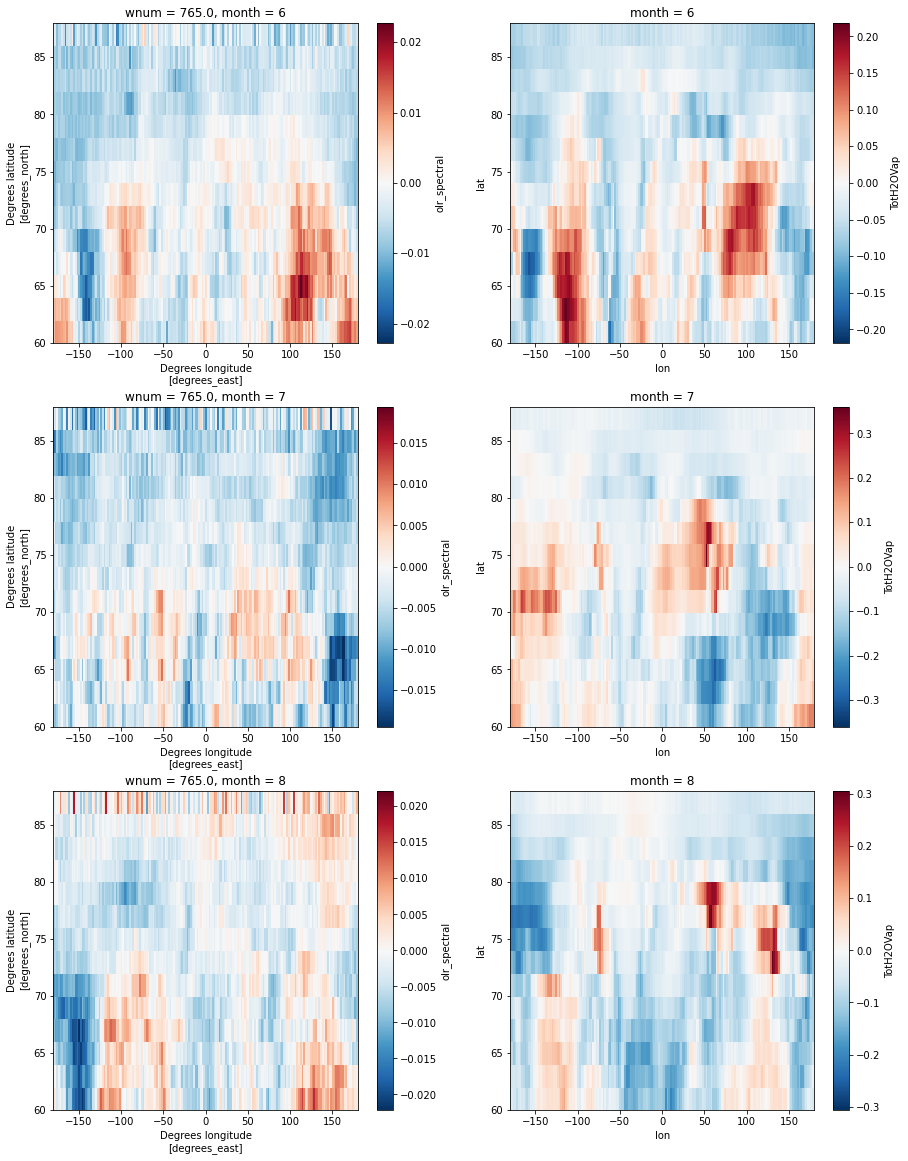

In [166]:
fig,axs = plt.subplots(3,2,figsize=(15,20))

for i_month,(_olr_month,_tmq_month,row_axs) in enumerate(zip(olr_jja_765_trends,tmq_net_jja_trends,axs)):
    
    _olr_month.plot(ax=row_axs[0])
    _tmq_month.plot(ax=row_axs[1])
    
    # break

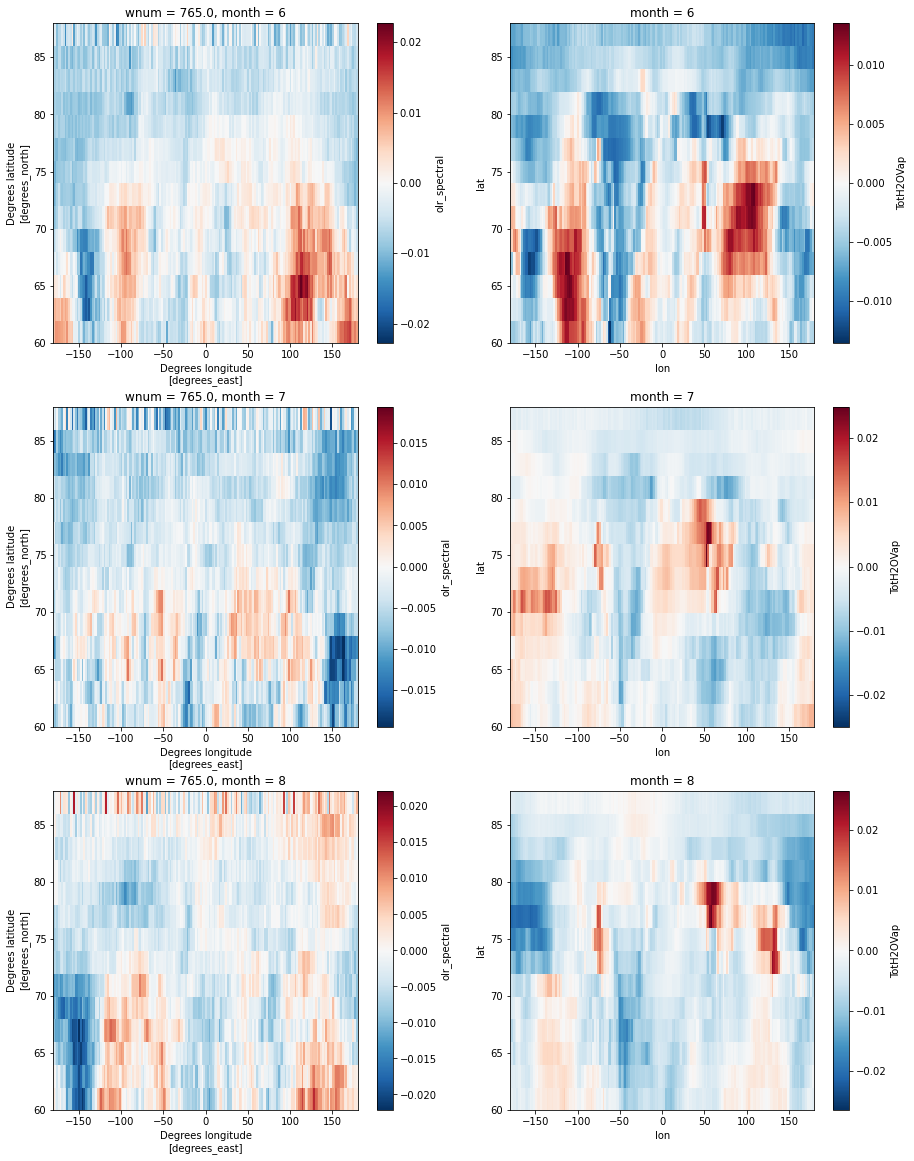

In [168]:
fig,axs = plt.subplots(3,2,figsize=(15,20))

for i_month,(_olr_month,_tmq_month,row_axs) in enumerate(zip(olr_jja_765_trends,tmq_log_jja_trends,axs)):
    
    _olr_month.plot(ax=row_axs[0])
    _tmq_month.plot(ax=row_axs[1])
    
    # break

#### Scatter plots the trends against each other

In [171]:
olr_jja_765_trends_stack = olr_jja_765_trends.stack(z=('month', 'lat','lon'))

tmq_net_jja_trends_stack = tmq_net_jja_trends.stack(z=('month', 'lat','lon'))
tmq_log_jja_trends_stack = tmq_log_jja_trends.stack(z=('month', 'lat','lon'))

Text(0, 0.5, 'Precipitable water vapor (kg m^-2) trend')

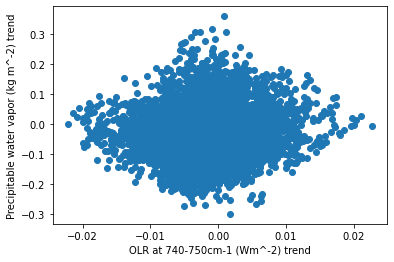

In [172]:
plt.scatter(olr_jja_765_trends_stack,tmq_net_jja_trends_stack)

plt.xlabel('OLR at 740-750cm-1 (Wm^-2) trend')
plt.ylabel('Precipitable water vapor (kg m^-2) trend')

Text(0, 0.5, 'Log of Precipitable water vapor (kg m^-2) trend')

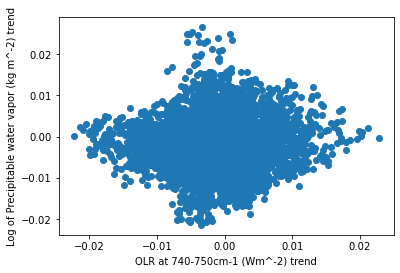

In [175]:
plt.scatter(olr_jja_765_trends_stack,tmq_log_jja_trends_stack)

plt.xlabel('OLR at 740-750cm-1 (Wm^-2) trend')
plt.ylabel('Log of Precipitable water vapor (kg m^-2) trend')

This doesn't look right to me, there isn't any correlation at all...

In [177]:
olr_dem_stack = olr_jja_765_trends[0].stack(z=('lat','lon'))
tmq_dem_stack = tmq_net_jja_trends[0].stack(z=('lat','lon'))

Text(0, 0.5, 'Log of Precipitable water vapor (kg m^-2) trend (June)')

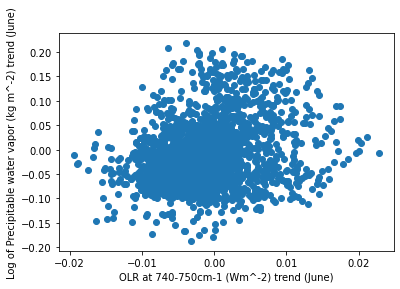

In [178]:
plt.scatter(olr_dem_stack,tmq_dem_stack)

plt.xlabel('OLR at 740-750cm-1 (Wm^-2) trend (June)')
plt.ylabel('Log of Precipitable water vapor (kg m^-2) trend (June)')

In [164]:
axs.shape

(3, 2)

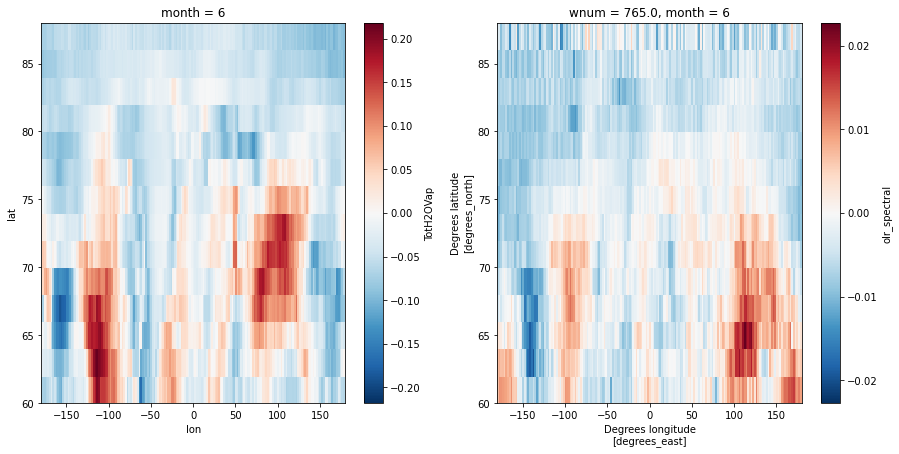

In [159]:
fig,axs = plt.subplots(1,2,figsize=(15,7))

tmq_net_jja_trends[0][0].plot(ax=axs[0])

olr_jja_765_trends[0][0].plot(ax=axs[1])

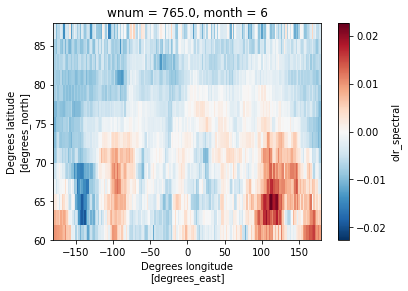

In [149]:
olr_jja_765_trends[0][0].plot()

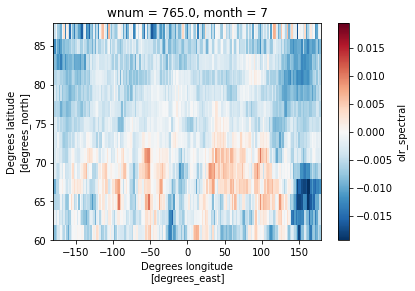

In [150]:
olr_jja_765_trends[0][1].plot()

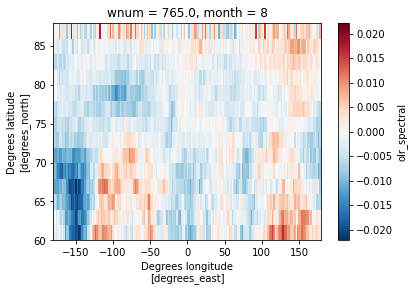

In [151]:
olr_jja_765_trends[0][2].plot()

In [117]:
stack_tmq.to_array()

AttributeError: 'DataArray' object has no attribute 'to_array'

In [116]:
stack_olr.to_array()

<xarray.DataArray (variable: 2, z: 120960)>
array([[2.6316595, 2.876533 , 2.65504  , ..., 2.4839406, 2.4797277,
        2.6241465],
       [2.9484181, 3.2169929,       nan, ..., 2.8212397, 2.7785034,
        2.8554149]], dtype=float32)
Coordinates:
    wnum         float32 765.0
    cell_weight  (z) float32 0.00061869685 0.00061869685 ... 6.6789165e-05
  * z            (z) MultiIndex
  - lat          (z) float64 61.0 61.0 61.0 61.0 61.0 ... 87.0 87.0 87.0 87.0
  - lon          (z) float64 -179.0 -179.0 -179.0 -179.0 ... 179.0 179.0 179.0
  - time         (z) datetime64[ns] 2003-06-15T12:00:00 ... 2018-08-15T12:00:00
  * variable     (variable) <U16 'olr_spectral' 'olr_clr_spectral'

In [113]:
stack_tmq

<xarray.DataArray 'TotH2OVap' (z: 120960)>
dask.array<reshape, shape=(120960,), dtype=float32, chunksize=(120960,), chunktype=numpy.ndarray>
Coordinates:
  * z        (z) MultiIndex
  - lat      (z) float64 61.0 61.0 61.0 61.0 61.0 ... 87.0 87.0 87.0 87.0 87.0
  - lon      (z) float64 -179.0 -179.0 -179.0 -179.0 ... 179.0 179.0 179.0 179.0
  - time     (z) datetime64[ns] 2003-06-15T12:00:00 ... 2018-08-15T12:00:00

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


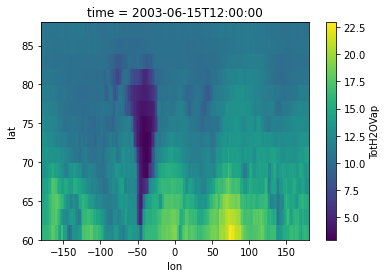

In [98]:
tmq_net_jja_interp[0].plot()

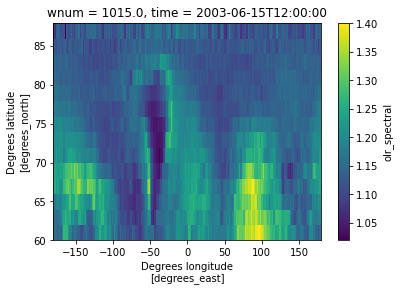

In [99]:
olr_jja_subset_notop['olr_spectral'].isel(time=0,wnum=100).plot()

In [89]:
tmq_net_jja.lat

<xarray.DataArray 'lat' (lat: 31)>
array([89.5, 88.5, 87.5, 86.5, 85.5, 84.5, 83.5, 82.5, 81.5, 80.5, 79.5, 78.5,
       77.5, 76.5, 75.5, 74.5, 73.5, 72.5, 71.5, 70.5, 69.5, 68.5, 67.5, 66.5,
       65.5, 64.5, 63.5, 62.5, 61.5, 60.5, 59.5])
Coordinates:
  * lat      (lat) float64 89.5 88.5 87.5 86.5 85.5 ... 63.5 62.5 61.5 60.5 59.5

In [90]:
olr_jja_subset_notop.lat

<xarray.DataArray 'lat' (lat: 15)>
array([59., 61., 63., 65., 67., 69., 71., 73., 75., 77., 79., 81., 83., 85.,
       87.], dtype=float32)
Coordinates:
  * lat      (lat) float32 59.0 61.0 63.0 65.0 67.0 ... 79.0 81.0 83.0 85.0 87.0
Attributes:
    units:                  degrees_north
    valid_range:            [-90.  90.]
    long_name:              Degrees latitude
    standard_name:          latitude
    axis:                   Y
    description:            Degrees latitude
    AIRS_name:              YDim
    coverage_content_type:  coordinate
    bounds:                 lat_bnds

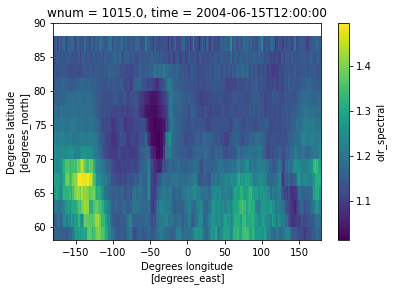

In [71]:
olr_jja_subset['olr_spectral'].isel(time=3,wnum=100).plot()

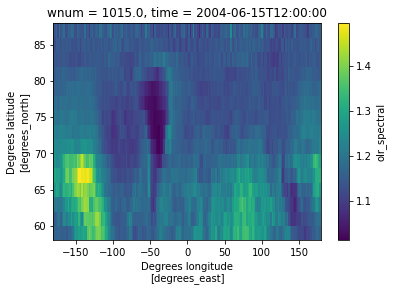

In [74]:
# Remove top empty latitude bin from AIRS spectral OLR
olr_jja_subset['olr_spectral'].sel(lat=slice(None,87))

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


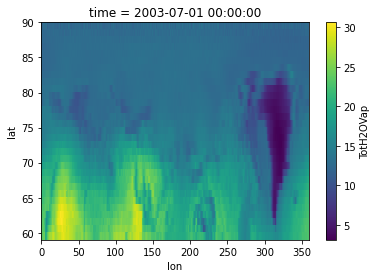

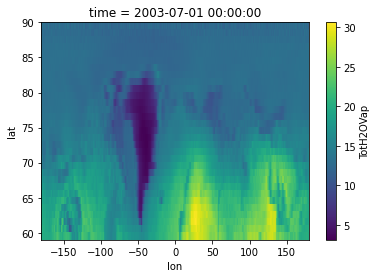

In [66]:
tmq_net_jja.isel(time=1).plot()
plt.figure()
tmq_net_jja_copy.isel(time=1).plot()
plt.figure()


In [60]:
(((tmq_net_jja_copy['lon'] + 180) % 360) - 180).sortby('lon')

<xarray.DataArray 'lon' (lon: 360)>
array([   0.,    1.,    2.,    3.,    4.,    5.,    6.,    7.,    8.,
          9.,   10.,   11.,   12.,   13.,   14.,   15.,   16.,   17.,
         18.,   19.,   20.,   21.,   22.,   23.,   24.,   25.,   26.,
         27.,   28.,   29.,   30.,   31.,   32.,   33.,   34.,   35.,
         36.,   37.,   38.,   39.,   40.,   41.,   42.,   43.,   44.,
         45.,   46.,   47.,   48.,   49.,   50.,   51.,   52.,   53.,
         54.,   55.,   56.,   57.,   58.,   59.,   60.,   61.,   62.,
         63.,   64.,   65.,   66.,   67.,   68.,   69.,   70.,   71.,
         72.,   73.,   74.,   75.,   76.,   77.,   78.,   79.,   80.,
         81.,   82.,   83.,   84.,   85.,   86.,   87.,   88.,   89.,
         90.,   91.,   92.,   93.,   94.,   95.,   96.,   97.,   98.,
         99.,  100.,  101.,  102.,  103.,  104.,  105.,  106.,  107.,
        108.,  109.,  110.,  111.,  112.,  113.,  114.,  115.,  116.,
        117.,  118.,  119.,  120.,  121.,  122.,  123.,  124.,  125.,
        126.,  127.,  128.,  129.,  130.,  131.,  132.,  133.,  134.,
        135.,  136.,  137.,  138.,  139.,  140.,  141.,  142.,  143.,
        144.,  145.,  146.,  147.,  148.,  149.,  150.,  151.,  152.,
        153.,  154.,  155.,  156.,  157.,  158.,  159.,  160.,  161.,
        162.,  163.,  164.,  165.,  166.,  167.,  168.,  169.,  170.,
        171.,  172.,  173.,  174.,  175.,  176.,  177.,  178.,  179.,
       -180., -179., -178., -177., -176., -175., -174., -173., -172.,
       -171., -170., -169., -168., -167., -166., -165., -164., -163.,
       -162., -161., -160., -159., -158., -157., -156., -155., -154.,
       -153., -152., -151., -150., -149., -148., -147., -146., -145.,
       -144., -143., -142., -141., -140., -139., -138., -137., -136.,
       -135., -134., -133., -132., -131., -130., -129., -128., -127.,
       -126., -125., -124., -123., -122., -121., -120., -119., -118.,
       -117., -116., -115., -114., -113., -112., -111., -110., -109.,
       -108., -107., -106., -105., -104., -103., -102., -101., -100.,
        -99.,  -98.,  -97.,  -96.,  -95.,  -94.,  -93.,  -92.,  -91.,
        -90.,  -89.,  -88.,  -87.,  -86.,  -85.,  -84.,  -83.,  -82.,
        -81.,  -80.,  -79.,  -78.,  -77.,  -76.,  -75.,  -74.,  -73.,
        -72.,  -71.,  -70.,  -69.,  -68.,  -67.,  -66.,  -65.,  -64.,
        -63.,  -62.,  -61.,  -60.,  -59.,  -58.,  -57.,  -56.,  -55.,
        -54.,  -53.,  -52.,  -51.,  -50.,  -49.,  -48.,  -47.,  -46.,
        -45.,  -44.,  -43.,  -42.,  -41.,  -40.,  -39.,  -38.,  -37.,
        -36.,  -35.,  -34.,  -33.,  -32.,  -31.,  -30.,  -29.,  -28.,
        -27.,  -26.,  -25.,  -24.,  -23.,  -22.,  -21.,  -20.,  -19.,
        -18.,  -17.,  -16.,  -15.,  -14.,  -13.,  -12.,  -11.,  -10.,
         -9.,   -8.,   -7.,   -6.,   -5.,   -4.,   -3.,   -2.,   -1.])
Coordinates:
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


ValueError: The input coordinate is not sorted in increasing order along axis 0. This can lead to unexpected results. Consider calling the `sortby` method on the input DataArray. To plot data with categorical axes, consider using the `heatmap` function from the `seaborn` statistical plotting library.

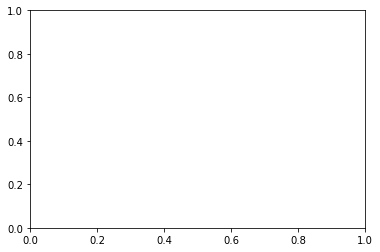

In [55]:
tmq_net_jja_copy.isel(time=1).plot()

In [46]:
(tmq_net_jja['lon'] - 360) % 180

<xarray.DataArray 'lon' (lon: 360)>
array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 150., 151., 152., 153.,
       154., 155., 156., 157., 158., 159., 160., 161., 162., 163., 164.,
       165., 166., 167., 168., 169., 170., 171., 172., 173., 174., 175.,
       176., 177., 178., 179.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,
         7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,
        18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,
        29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,
        40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,
        51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,
        62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,
        73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
        84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,
        95.,  96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105.,
       106., 107., 108., 109., 110., 111., 112., 113., 114., 115., 116.,
       117., 118., 119., 120., 121., 122., 123., 124., 125., 126., 127.,
       128., 129., 130., 131., 132., 133., 134., 135., 136., 137., 138.,
       139., 140., 141., 142., 143., 144., 145., 146., 147., 148., 149.,
       150., 151., 152., 153., 154., 155., 156., 157., 158., 159., 160.,
       161., 162., 163., 164., 165., 166., 167., 168., 169., 170., 171.,
       172., 173., 174., 175., 176., 177., 178., 179.])
Coordinates:
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0

In [47]:
((tmq_net_jja['lon'] + 180) % 360) - 180

<xarray.DataArray 'lon' (lon: 360)>
array([   0.,    1.,    2.,    3.,    4.,    5.,    6.,    7.,    8.,
          9.,   10.,   11.,   12.,   13.,   14.,   15.,   16.,   17.,
         18.,   19.,   20.,   21.,   22.,   23.,   24.,   25.,   26.,
         27.,   28.,   29.,   30.,   31.,   32.,   33.,   34.,   35.,
         36.,   37.,   38.,   39.,   40.,   41.,   42.,   43.,   44.,
         45.,   46.,   47.,   48.,   49.,   50.,   51.,   52.,   53.,
         54.,   55.,   56.,   57.,   58.,   59.,   60.,   61.,   62.,
         63.,   64.,   65.,   66.,   67.,   68.,   69.,   70.,   71.,
         72.,   73.,   74.,   75.,   76.,   77.,   78.,   79.,   80.,
         81.,   82.,   83.,   84.,   85.,   86.,   87.,   88.,   89.,
         90.,   91.,   92.,   93.,   94.,   95.,   96.,   97.,   98.,
         99.,  100.,  101.,  102.,  103.,  104.,  105.,  106.,  107.,
        108.,  109.,  110.,  111.,  112.,  113.,  114.,  115.,  116.,
        117.,  118.,  119.,  120.,  121.,  122.,  123.,  124.,  125.,
        126.,  127.,  128.,  129.,  130.,  131.,  132.,  133.,  134.,
        135.,  136.,  137.,  138.,  139.,  140.,  141.,  142.,  143.,
        144.,  145.,  146.,  147.,  148.,  149.,  150.,  151.,  152.,
        153.,  154.,  155.,  156.,  157.,  158.,  159.,  160.,  161.,
        162.,  163.,  164.,  165.,  166.,  167.,  168.,  169.,  170.,
        171.,  172.,  173.,  174.,  175.,  176.,  177.,  178.,  179.,
       -180., -179., -178., -177., -176., -175., -174., -173., -172.,
       -171., -170., -169., -168., -167., -166., -165., -164., -163.,
       -162., -161., -160., -159., -158., -157., -156., -155., -154.,
       -153., -152., -151., -150., -149., -148., -147., -146., -145.,
       -144., -143., -142., -141., -140., -139., -138., -137., -136.,
       -135., -134., -133., -132., -131., -130., -129., -128., -127.,
       -126., -125., -124., -123., -122., -121., -120., -119., -118.,
       -117., -116., -115., -114., -113., -112., -111., -110., -109.,
       -108., -107., -106., -105., -104., -103., -102., -101., -100.,
        -99.,  -98.,  -97.,  -96.,  -95.,  -94.,  -93.,  -92.,  -91.,
        -90.,  -89.,  -88.,  -87.,  -86.,  -85.,  -84.,  -83.,  -82.,
        -81.,  -80.,  -79.,  -78.,  -77.,  -76.,  -75.,  -74.,  -73.,
        -72.,  -71.,  -70.,  -69.,  -68.,  -67.,  -66.,  -65.,  -64.,
        -63.,  -62.,  -61.,  -60.,  -59.,  -58.,  -57.,  -56.,  -55.,
        -54.,  -53.,  -52.,  -51.,  -50.,  -49.,  -48.,  -47.,  -46.,
        -45.,  -44.,  -43.,  -42.,  -41.,  -40.,  -39.,  -38.,  -37.,
        -36.,  -35.,  -34.,  -33.,  -32.,  -31.,  -30.,  -29.,  -28.,
        -27.,  -26.,  -25.,  -24.,  -23.,  -22.,  -21.,  -20.,  -19.,
        -18.,  -17.,  -16.,  -15.,  -14.,  -13.,  -12.,  -11.,  -10.,
         -9.,   -8.,   -7.,   -6.,   -5.,   -4.,   -3.,   -2.,   -1.])
Coordinates:
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0

In [44]:
tmq_net_jja['lon'] % 360

<xarray.DataArray 'lon' (lon: 360)>
array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 150., 151., 152., 153.,
       154., 155., 156., 157., 158., 159., 160., 161., 162., 163., 164.,
       165., 166., 167., 168., 169., 170., 171., 172., 173., 174., 175.,
       176., 177., 178., 179.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,
         7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,
        18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,
        29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,
        40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,
        51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,
        62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,
        73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
        84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,
        95.,  96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105.,
       106., 107., 108., 109., 110., 111., 112., 113., 114., 115., 116.,
       117., 118., 119., 120., 121., 122., 123., 124., 125., 126., 127.,
       128., 129., 130., 131., 132., 133., 134., 135., 136., 137., 138.,
       139., 140., 141., 142., 143., 144., 145., 146., 147., 148., 149.,
       150., 151., 152., 153., 154., 155., 156., 157., 158., 159., 160.,
       161., 162., 163., 164., 165., 166., 167., 168., 169., 170., 171.,
       172., 173., 174., 175., 176., 177., 178., 179.])
Coordinates:
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0